In [6]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 2.4 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 23.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.4 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 27.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 15.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
####################################################################
# Imports and given constants and classes to be used in your code
# DO NOT CHANGE ANY OF THE BELOW
####################################################################
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle 
import math

# UNITS USED
# Time: Astronomical Units (AU). 1AU = distance between Sun and earth
# Mass: Solar Mass (M_sun). 1M_sun = mass of the Sun
# Time: Year (yr). 1yr = 1 year (one rotation of the Earth around the Sun)
# Luminosity: Solar Luminosity (L_sun). 1L_sun = luminosity of the Sun
# Velocity: AU/yr

G = 4*(math.pi)**2  # Universal gravitational constant (AU^3/M_sun/yr^2)
scoeff = 22.62      # Scorching coefficient, approx. 0.745 AU from the Sun (L_sun/AU^2)
fcoeff = 3.14       # Freezing coefficient, approx. 2 AU from the Sun (L_sun/AU^2)

class Box:
    def __init__(self,x0,y0,x1,y1):
        self.x0, self.y0, self.x1, self.y1 = x0, y0, x1, y1
        self.maxSide = max(self.x1-self.x0,self.y1-self.y0)
        self.mx = (self.x0+self.x1)/2
        self.my = (self.y0+self.y1)/2
        
    def isIn(self,p):
        return self.x0 <= p.x <= self.x1 and self.y0 <= p.y <= self.y1
    
    def asTuple(self):
        return (self.x0,self.y0,self.x1,self.y1,self.mx,self.my)
    
    def split4(self):
        bNE = Box(self.mx,self.my,self.x1,self.y1)
        bNW = Box(self.x0,self.my,self.mx,self.y1)
        bSW = Box(self.x0,self.y0,self.mx,self.my)
        bSE = Box(self.mx,self.y0,self.x1,self.my)
        return (bNE,bNW,bSW,bSE)

    # Build a box that encloses all Bodies from an array 
    @staticmethod
    def getBox(P):
        if len(P) == 0: return None
        x0 = x1 = P[0].x
        y0 = y1 = P[0].y
        for p in P: 
            if p.x < x0: x0 = p.x
            if p.y < y0: y0 = p.y
            if p.x > x1: x1 = p.x
            if p.y > y1: y1 = p.y
        return Box(x0,y0,x1,y1)    
    
    def __str__(self):
        return f"Box({self.x0},{self.y0},{self.x1},{self.y1})"
        
class GNode:
    def __init__(self,box):
        self.box = box
        self.COM = None           # this node’s COM
        self.nbodies = 0          # number of bodies contained in node
        self.p = None             # if this node is a leaf with a Body
        self.children = None      # children are: [NE, NW, SW, SE]
        self.updateCOM()

    def isLeaf(self):
        return self.nbodies < 2
        
    def updateCOM(self):
        if self.isLeaf(): 
            if self.p == None:
                self.COM = Body(0, self.box.mx, self.box.my)
            else:
                self.COM = Body(self.p.m, self.p.x, self.p.y)
            return
        x = y = m = 0
        for c in self.children:
            x += c.COM.x*c.COM.m
            y += c.COM.y*c.COM.m
            m += c.COM.m
        self.COM = Body(m, x/m, y/m)

    def niceStr(self): 
        S = ("├","─","└","│")
        angle = S[2]+S[1]+" "
        vdash = S[0]+S[1]+" "
        
        def niceRec(ptr,acc,pre,A):
            if ptr == None: raise Exception("A None GNode was found")
            val = f"{len(A)}:{ptr.box},{ptr.nbodies}"
            A.append(f"({ptr.COM.m}, {ptr.COM.x}, {ptr.COM.y})")
            if ptr.children==None: return acc+pre+val
            if pre == vdash: pre2 = S[3]+"  "
            elif pre == angle: pre2 = "   "
            else: pre2 = ""
            T = [vdash,vdash,vdash,angle]
            for i in range(4):
                T[i] = niceRec(ptr.children[i],acc+pre2,T[i],A)
            return acc+pre+val+"\n"+T[0]+"\n"+T[1]+"\n"+T[2]+"\n"+T[3]
            
        A = []
        s = niceRec(self,"","",A)+"\n"
        for i in range(len(A)):
            s += f"\n{i}{' '*(3-len(str(i)))}-> {A[i]}"
        return s
    
class Stack:
    def __init__(self):
        self.inList = []
        
    def push(self,v):
        self.inList.append(v)

    def pop(self):
        if len(self.inList) == 0: raise Exception("Popping from an empty stack")
        return self.inList.pop()
    
    def isEmpty(self):
        return len(self.inList) == 0
    
    def size(self):
        return len(self.inList)

    def toArray(self):
        return self.inList
    
    def __str__(self):
        return str(self.inList)

In [11]:
####################################################################
# Question 1: Intro to the n-body problem
# To solve: closest distance, predict good eras in 3-body problem
####################################################################

class Body:
    def __init__(self,m,x,y,vx=0,vy=0):
        self.m = m     # mass
        self.x = x     # position
        self.y = y     # position
        self.vx = vx   # velocity
        self.vy = vy   # velocity
        
    def squareDist(self,other):
        return (self.x-other.x)**2+(self.y-other.y)**2

    def __str__(self):
        return f"Body({self.m},{self.x},{self.y},{self.vx},{self.vy})"    

    def __repr__(self):
        return str(self)    

    def asTuple(self):
        return (self.m,self.x,self.y,self.vx,self.vy)    
    
    # Gives the next position and velocity of the current Body to its position
    # and velocity after time dt las elapsed, taking into account the pull
    # forces from the bodies in the array Bodies.
    def next(self, Bodies, dt):
        ret = Body(self.m, self.x, self.y)
        ax = ay = 0       
        # for each p in Bodies we compute their force on this Body and add it to its acceleration 
        for p in Bodies:
            if p == self: continue # current Body does not affect itself          
            # euclidian distance between p and this Body
            sq_distance = self.squareDist(p)
            # see e.g. https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation
            # for the vector form of Newton's law of gravity            
            ax += (p.x - self.x) *  p.m * G / (sq_distance**1.5)
            ay += (p.y - self.y) *  p.m * G / (sq_distance**1.5)
        # we compute displacement due to acceleration that we computed above
        # and due to its current speed because of inertia        
        ret.x += dt*dt*ax + dt*self.vx
        ret.y += dt*dt*ay + dt*self.vy
        # compute the velocity vectors
        ret.vx = (ret.x-self.x)/dt
        ret.vy = (ret.y-self.y)/dt

        return ret

    # Predict years of stability that self planet is going to have in a 3-sun solar system.
    # It suffices to take into account just the three suns (sunA,sunB,sunC) and the planet.
    # Stability is broken if one of the following criteria is violated: 
    # a. No scorching: lA/dA + lB/dB + lC/dC must be less than scoeff
    # b. No freezing: lA/dA + lB/dB + lC/dC must be greater than fcoeff
    # Notes: 
    # - dA, dB, dC are the squared distances between sunA, sunB, sunC and self, and 
    # - lA, lB, lC are the luminosities of sunA, sunB, sunC 
    # respectively. 
    def threeBodyProblem(self,sunA,sunB,sunC,lA,lB,lC): # 15%
        
        # clone bodies so old values arent used in updates
        planet = Body(self.m, self.x, self.y, self.vx, self.vy)
        sA = Body(sunA.m, sunA.x, sunA.y, sunA.vx, sunA.vy)
        sB = Body(sunB.m, sunB.x, sunB.y, sunB.vx, sunB.vy)
        sC = Body(sunC.m, sunC.x, sunC.y, sunC.vx, sunC.vy)
        
        planet_temp_stable = True
        years_habitable = 0.0
        dt = 0.01
        
        while (planet_temp_stable == True):
            
            # calculate the planets heat
            planet_heat = (lA/planet.squareDist(sA)) + (lB/planet.squareDist(sB)) + (lC/planet.squareDist(sC))
    
            # if the planets heat is not suitable then break out of the while loop
            if planet_heat > scoeff or planet_heat < fcoeff:
                planet_temp_stable = False
                break
    
            # update the mass, position and velocity values of the planet AND the 3 suns using the next function
            bodies = [sA, sB, sC, planet]
            next_bodies = [b.next(bodies, dt) for b in bodies]
            sA, sB, sC, planet = next_bodies
    
            years_habitable += dt
    
        return round(years_habitable, 2)
    
class Simulation:
    # Default simulation time 10yr, step time 0.01yr
    def __init__(self, Bodies, total_time = 10, dt=0.01):
        self.bodies = Bodies
        self.total_time = total_time
        self.dt = dt
        self.timesteps = int(total_time/dt)
        
    # Runs the simulation and produces an array of arrays of Bodies.
    # The t-th entry in the list is the position of Bodies after the t-th timestep
    # has been simulated    
    def run(self):
        pss = [None]*(self.timesteps+1)
        pss[0] = self.bodies
        for t in range(self.timesteps):
            # for every Body in the current timestep add its next position in next timestep
            pss[t+1] = [pss[t][i].next(pss[t],self.dt) for i in range(len(self.bodies))]
        return pss
   
   #################################################################################################################################
    def closestDistance(self): # 15%
        if (len(self.bodies) < 2):
            

            # run sim to get all positions
            pss = self.run()
    
            min_distance_sq = float('inf')
    
            # go through all time steps
            for timestep in pss:
                bodies_at_timestep = timestep
    
                # compare all distinct pairs
                for i in range(len(bodies_at_timestep)):
                    for j in range(i+1, len(bodies_at_timestep)):
                        body1 = bodies_at_timestep[i]
                        body2 = bodies_at_timestep[j]
    
                        # calculate square distance
                        distance_sq = body1.squareDist(body2)
    
                        if distance_sq < min_distance_sq:
                            min_distance_sq = distance_sq
    
            # return sqrt distance
            return math.sqrt(min_distance_sq)


    ################################################################################################################################
    
    # Shows an animation of the simulation using matplotlib
    def show(self,x0,y0,x1,y1):
        pss = self.run()
        # get figure and axes objects
        fig, ax = plt.subplots()
        # set some reasonable zoom on axes
        ax.set_xlim(x0,x1)
        ax.set_ylim(y0,y1)
        # put labels on the window for Bodies with different colours
        scatter = []
        for i in range(len(self.bodies)):
            scatter.append(ax.scatter([], [], marker='o', label=f'Body {i}'))
         # add timestep text to the legend
        time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                       verticalalignment='top', bbox=dict(boxstyle='round', 
                       facecolor='wheat', alpha=0.5))
        # update function from one position to the next
        def update(frame):
            for i in range(len(self.bodies)):
                scatter[i].set_offsets([pss[frame][i].x, pss[frame][i].y])
            time_text.set_text(f'Timestep: {frame}')                
            return scatter + [time_text]
        # generate and show the animation
        a = FuncAnimation(fig, update, frames=len(pss), interval=1, blit=True, repeat=False)
        plt.xlabel("X coordinate (AU)")
        plt.ylabel("Y coordinate (AU)")
        plt.title("Celestial body trajectories")
        plt.legend()
        plt.show()    

In [12]:
####################################################################
# Question 2: The tree Gadget
# To solve: add and remove elements on a Gadget
####################################################################


class Gadget:
    def __init__(self,box):
        self.root = GNode(box)
        self.size = 0
        
    # Add Body p to this Gadget [30% TODO]        
    def add(self,p): 
        # Start from the root and keep a path of nodes for later updates
        node = self.root
        path = []
        
        # Traverse down to the correct leaf node by selecting a child whose box contains p
        while node.children is not None:
            path.append(node)
            ch = node.children
            if ch[0].box.isIn(p):
                node = ch[0]
            elif ch[1].box.isIn(p):
                node = ch[1]
            elif ch[2].box.isIn(p):
                node = ch[2]
            else:
                node = ch[3]

        # if the leaf node is empty, place p here and update upwards
        if node.p is None:
            node.p = p
            node.nbodies = 1
            node.updateCOM()
            self.size += 1
            # recalculate nbodies and COM on the path back to the root node
            i = len(path) - 1
            while i >= 0:
                n = path[i]
                total = 0
                j = 0
                while j < 4:
                    total += n.children[j].nbodies
                    j += 1
                n.nbodies = total
                n.updateCOM()
                i -= 1
            return

        # if the leaf node already has a body, we need to split it until p and the existing body are in different leaves
        while True:
            p0 = node.p
            node.p = None
            # create 4 children for the current node
            boxes = node.box.split4()
            node.children = [GNode(boxes[0]), GNode(boxes[1]), GNode(boxes[2]), GNode(boxes[3])]

            # Insert the existing body p0 into the appropriate child node
            if node.children[0].box.isIn(p0):
                c0 = node.children[0]
            elif node.children[1].box.isIn(p0):
                c0 = node.children[1]
            elif node.children[2].box.isIn(p0):
                c0 = node.children[2]
            else:
                c0 = node.children[3]
            c0.p = p0
            c0.nbodies = 1
            c0.updateCOM()

            # Select the child node for the new body p
            if node.children[0].box.isIn(p):
                c = node.children[0]
            elif node.children[1].box.isIn(p):
                c = node.children[1]
            elif node.children[2].box.isIn(p):
                c = node.children[2]
            else:
                c = node.children[3]

            # If that child node is an empty leaf, place p here and finish this split
            if c.p is None and c.children is None:
                c.p = p
                c.nbodies = 1
                c.updateCOM()
                # Update this internal node (sum nbodies and COM)
                total_here = 0
                k = 0
                while k < 4:
                    total_here += node.children[k].nbodies
                    k += 1
                node.nbodies = total_here
                node.updateCOM()
                break
            else:
                # Collision again, remember this node in the path and go deeper
                path.append(node)
                node = c

        # After inserting, update nbodies and COM on the stored path back up to the root node
        i = len(path) - 1
        while i >= 0:
            n = path[i]
            total = 0
            j = 0
            while j < 4:
                total += n.children[j].nbodies
                j += 1
            n.nbodies = total
            n.updateCOM()
            i -= 1

        # Increment size
        self.size += 1
        
    # Remove Body p from this Gadget [20% TODO]
    def remove(self, p):
        # helper function to go through the tree recursivly
        def _remove(node, p):
            if node is None:
                return False   # empty node nothing to remove

            # check if body p lies in current node's box
            if not node.box.isIn(p):
                return False

            # case 1: node is a leaf
            if node.children is None:
                # if the leaf contains the body we want
                if node.p is not None and node.p == p:
                    node.p = None
                    node.nbodies = 0
                    # reset COM to zero mass at center of box
                    node.COM = Body(0, node.box.mx, node.box.my)
                    return True
                else:
                    return False

            # case 2: node has children then go deeper
            removed = False
            for child in node.children:
                if child.box.isIn(p):
                    removed = _remove(child, p)
                    break

            # if removed from child, update this node
            if removed:
                node.nbodies = node.nbodies - 1  # one less body here

                # count non-empty children to check for false internal nodes
                non_empty = []
                keep_body = None
                for c in node.children:
                    if c.nbodies > 0:
                        non_empty.append(c)
                        if c.children is None and c.p is not None:
                            keep_body = c.p

                # if only one child has something, collapse node back to leaf
                if len(non_empty) == 1:
                    node.children = None
                    node.p = keep_body
                    node.nbodies = 1 if keep_body is not None else 0

                # recalcualte the COM for this node
                node.updateCOM()

            return removed

        # start from the root
        removed = _remove(self.root, p)
        if removed:
            # update gadget size only if something was really removed
            if self.size > 0:
                self.size = self.size - 1


    def __str__(self):
        return self.root.niceStr()

    # Collect all Bodies from this Gadget and return them in an array
    def getBodies(self):
        A = [None]*self.size
        i = 0; stack = Stack(); stack.push(self.root)
        while not stack.isEmpty():
            n = stack.pop()
            if n.isLeaf():
                if n.p is not None:
                    A[i] = n.p
                    i += 1
            else:
                for c in n.children: stack.push(c)
        return A   

    # Build a new Gadget and add in it all Bodies from array ps
    @staticmethod
    def fromBodies(ps):
        # calculate bottom-left and top-right positions
        if ps == []: return None
        x0 = x1 = ps[0].x
        y0 = y1 = ps[0].y
        for p in ps:
            if p.x < x0: x0 = p.x
            elif p.x > x1: x1 = p.x
            if p.y < y0: y0 = p.y
            elif p.y > y1: y1 = p.y
        # build gadget and add bodies 
        g = Gadget(Box(x0,y0,x1,y1))
        for p in ps: g.add(p)
        return g    
    
    @staticmethod
    def _drawNode(ax, node, showCom):
        x0, y0, x1, y1, mx, my = node.box.asTuple()
        w = x1-x0; h = y1-y0
        # draw the node rectangle
        rect = Rectangle((x0, y0), w, h, fill=False, linewidth=0.8, alpha=0.5)
        ax.add_patch(rect)
        # draw COM for internal nodes
        if showCom and not node.isLeaf():
            ax.plot([node.COM.x], [node.COM.y], marker='+', markersize=6)
            ax.plot([mx, node.COM.x], [my, node.COM.y], linewidth=0.3)            
        # draw leaf contents
        if node.isLeaf(): 
            if node.p is not None:
                ax.plot([node.p.x], [node.p.y], marker='o', markersize=3)
        else:
            # recurse into children [NE, NW, SW, SE]
            for c in node.children:
                if c is not None:
                    Gadget._drawNode(ax, c, showCom)
                
    def plot(self, figsize=(6,6)): # figsize : (w,h) in inches
        showCom=True         # Draw line with '+' from center to COM of internal nodes
        margin_ratio=0.05    # Extra margin around the root box
        fig, ax = plt.subplots(figsize=figsize)
        # Plot node bounds
        Gadget._drawNode(ax, self.root, showCom)
        # collect Bodies from leaves
        A = self.getBodies()
        if A != []:
            xs, ys = zip(*[(A[i].x,A[i].y) for i in range(len(A))])
            ax.plot(xs, ys, linestyle='none', marker='o', markersize=3)
        # Set view limits from root box (with margin)
        x0, y0, x1, y1, mx, my = self.root.box.asTuple()
        dx, dy = x1-x0, y1-y0
        pad_x = margin_ratio * max(dx, 1e-12)
        pad_y = margin_ratio * max(dy, 1e-12)
        ax.set_xlim(x0-pad_x, x1+pad_x)
        ax.set_ylim(y0-pad_y, y1+pad_y)
        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.show()

In [19]:
####################################################################
# Question 3: Using the Gadget to speed up simulations
# To solve: get bodies from a Gadget wrt reference body 
####################################################################

class FastSimulation(Simulation):
    # Runs the simulation and produces an array of arrays of Bodies.
    # The t-th entry in the list is the position of Bodies after the t-th timestep
    # has been simulated.
    # Simulation uses a Gadget in order to approximate for each body the list 
    # of other bodies gravitationally affecting its trajectory.
    def run(self,test=None): 
        pss = [None]*(self.timesteps+1)
        pss[0] = self.bodies
        for t in range(self.timesteps):
            # calculate the current Gadget
            g = Gadget.fromBodies(pss[t])
            # for every Body in the current timestep add its next position in next timestep
            # but using the gadget g
            A = pss[t][:]
            for i in range(len(A)):
                new_ps = FastSimulation.getBodies(g,A[i])
                A[i] = A[i].next(new_ps,self.dt)
                if test is not None: test[i] = new_ps
            pss[t+1] = A
        return pss

    # Barnes-Hut criterion deciding whether node n should be opened when calculating
    # the gravitational forces exerted on body p.
    # By defualt, if p is in n then we open.
    @staticmethod
    def BarnesHut(n,p):
        theta = 0.7
        if n.box.isIn(p): return True
        sqDist = (n.COM.x-p.x)**2+(n.COM.y-p.y)**2
        return n.box.maxSide**2/sqDist >= theta**2
        
    # Get bodies from gadget g in an optimal way, using criterion shouldOpen and body p to 
    # decide whether nodes in the gadget should be "opened" (i.e. their subnodes examined)
    # or not (i.e. the whole subtree approximated by its COM).
    @staticmethod
    def getBodies(g,p,shouldOpen=BarnesHut): # 20%
        new_ps = Stack() 
        stack = Stack()

        stack.push(g.root)

        while(stack.size() > 0):
            node = stack.pop()
            if(node is None or node.nbodies == 0):
                continue

            # if the node is a leaf, add to the new_ps stack
            if(node.isLeaf()):
                if(node.p is not None):
                    new_ps.push(node.p)

            else:
                if(shouldOpen(node, p)):
                    for c in node.children:
                        stack.push(c)

                else:
                    if(node.COM is not None):
                        new_ps.push(node.COM)

        result = [None]* new_ps.size()
        i = new_ps.size() - 1
        while (new_ps.size() > 0):
            result[i] = new_ps.pop()
            i -= 1

        return result

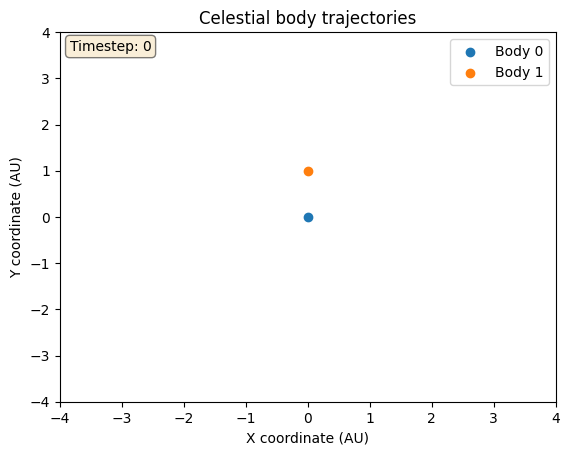

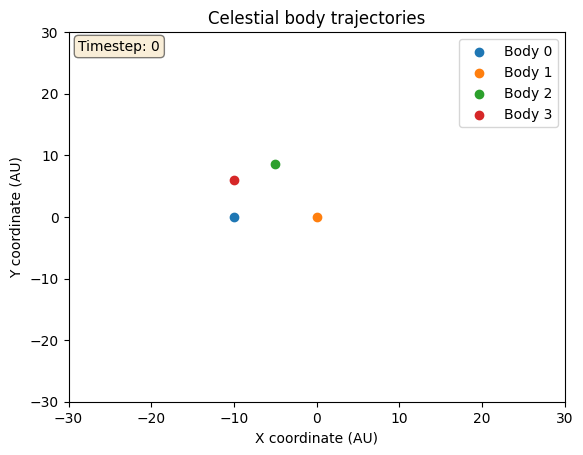

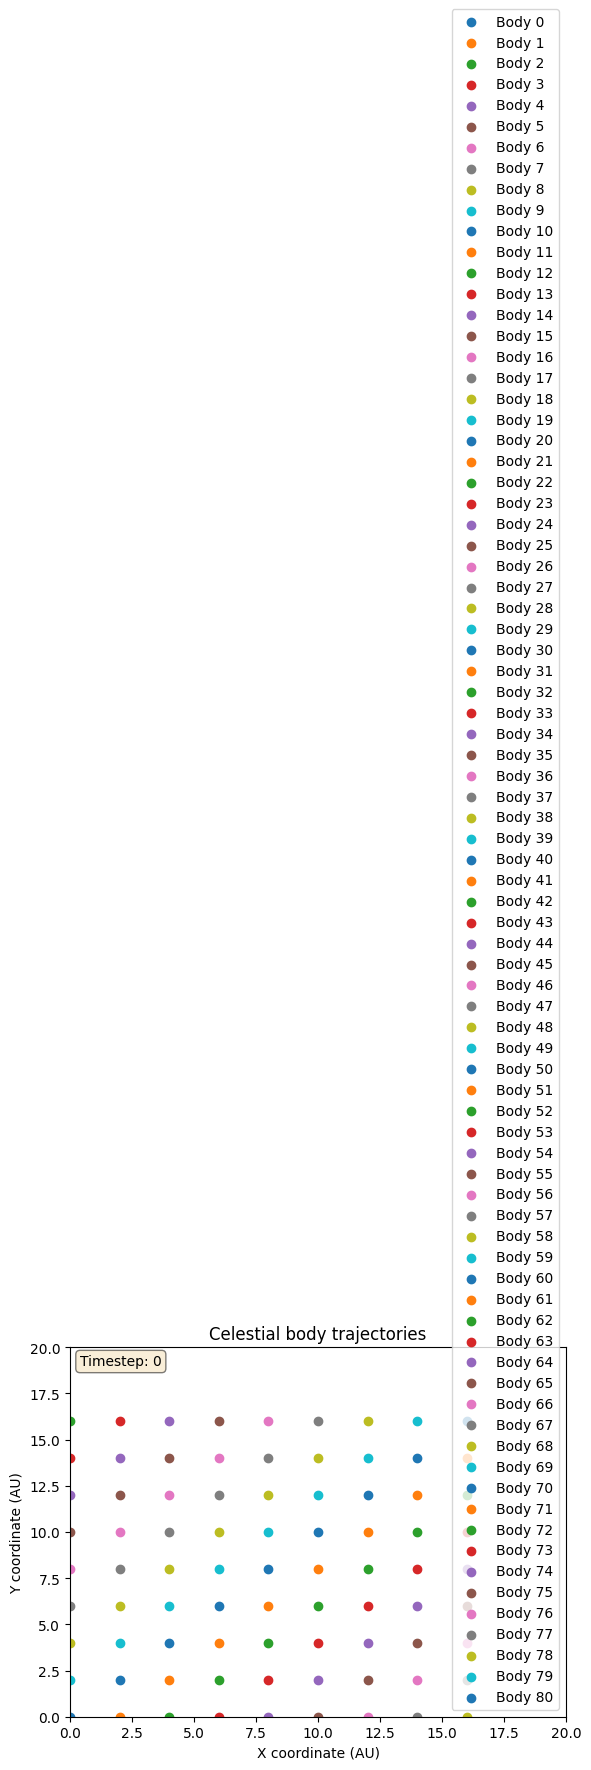

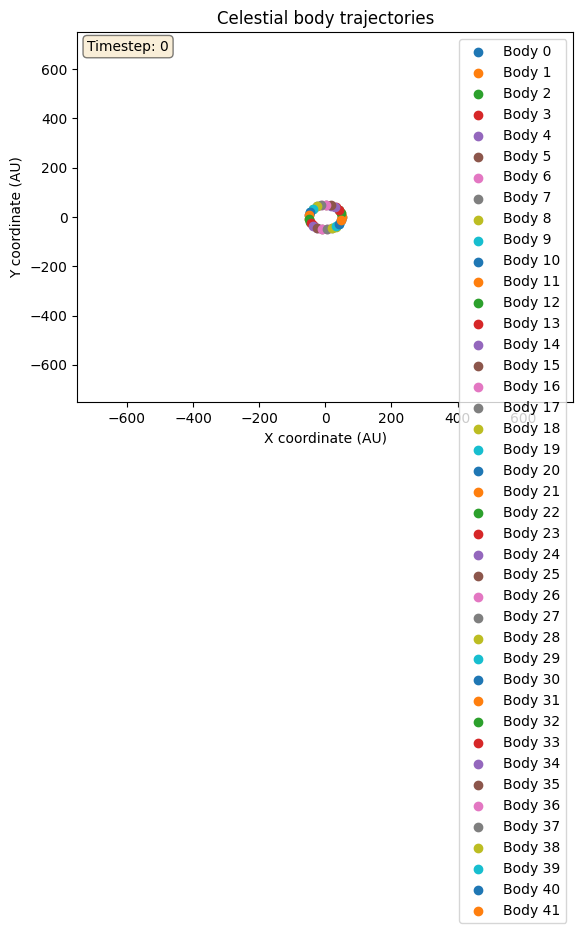

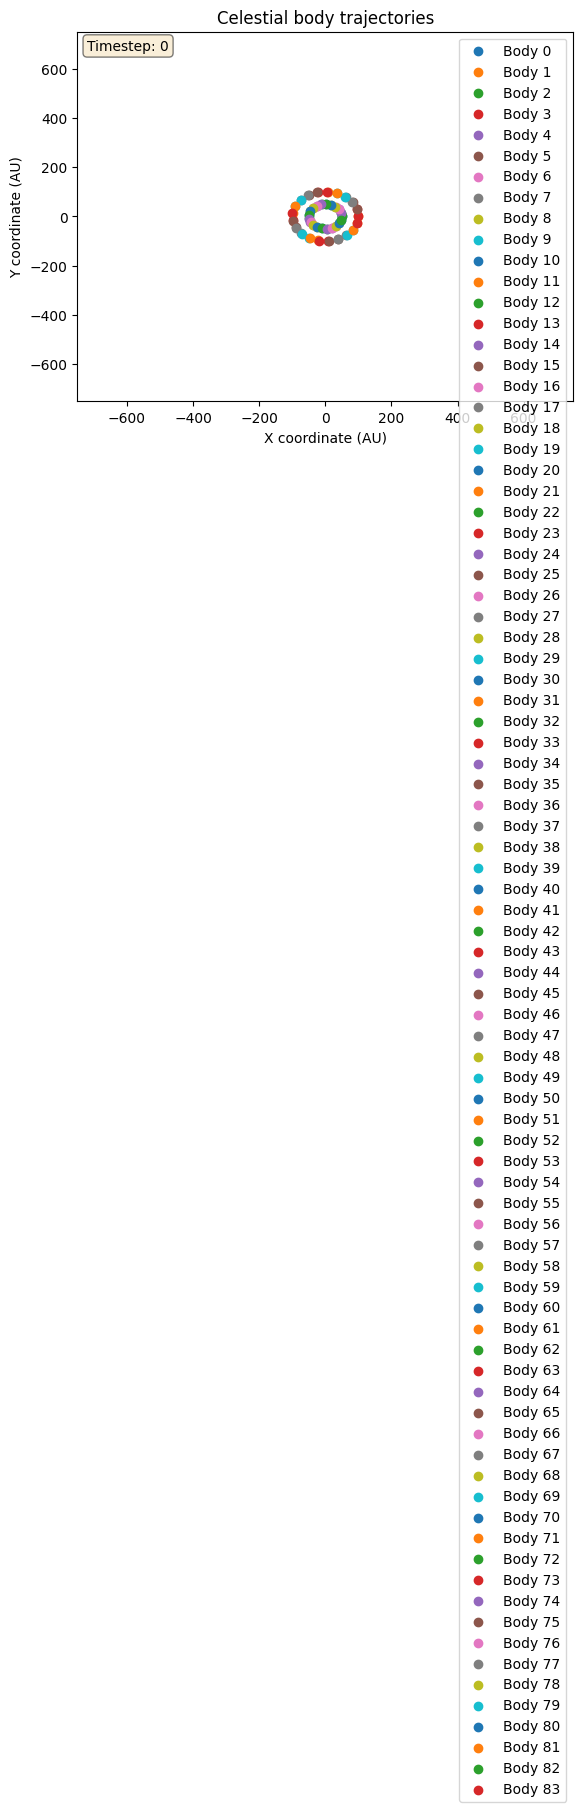

None
None
0.42
0.0
0:Box(-50,-50,50,50),4
├─ 1:Box(0.0,0.0,50,50),1
├─ 2:Box(-50,0.0,0.0,50),1
├─ 3:Box(-50,-50,0.0,0.0),1
└─ 4:Box(0.0,-50,50,0.0),1

0  -> (4, 0.0, 0.0)
1  -> (1, 50, 50)
2  -> (1, -50, 50)
3  -> (1, -50, -50)
4  -> (1, 50, -50)


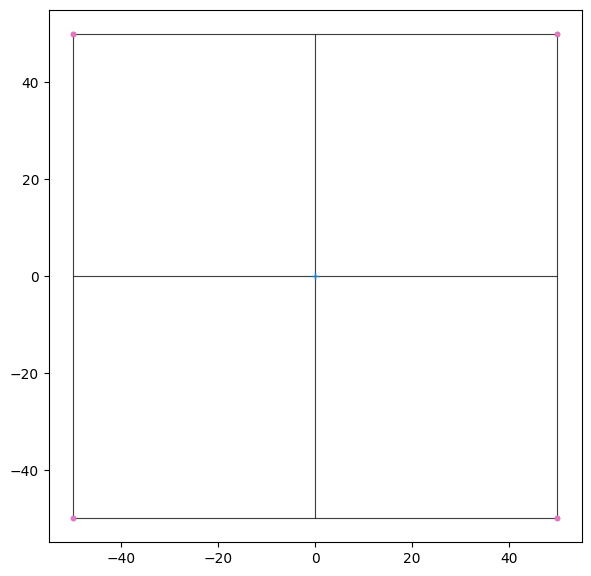

0:Box(-50,-50,50,50),3
├─ 1:Box(0.0,0.0,50,50),0
├─ 2:Box(-50,0.0,0.0,50),1
├─ 3:Box(-50,-50,0.0,0.0),1
└─ 4:Box(0.0,-50,50,0.0),1

0  -> (3, -16.666666666666668, -16.666666666666668)
1  -> (0, 25.0, 25.0)
2  -> (1, -50, 50)
3  -> (1, -50, -50)
4  -> (1, 50, -50)


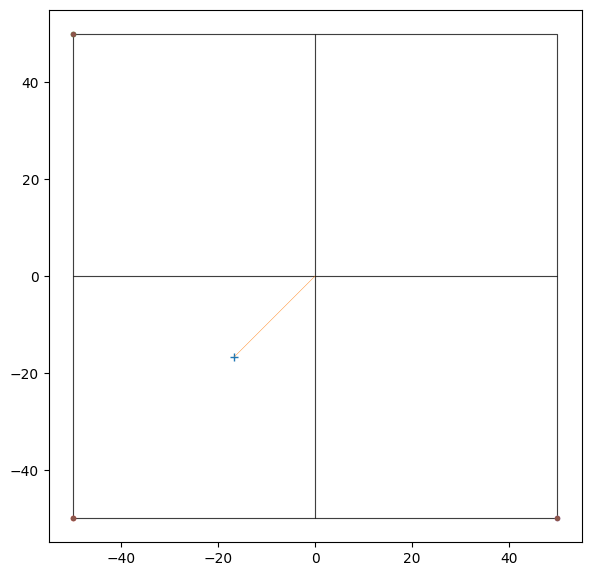

0:Box(-50,-50,50,50),1

0  -> (1, 50, -50)


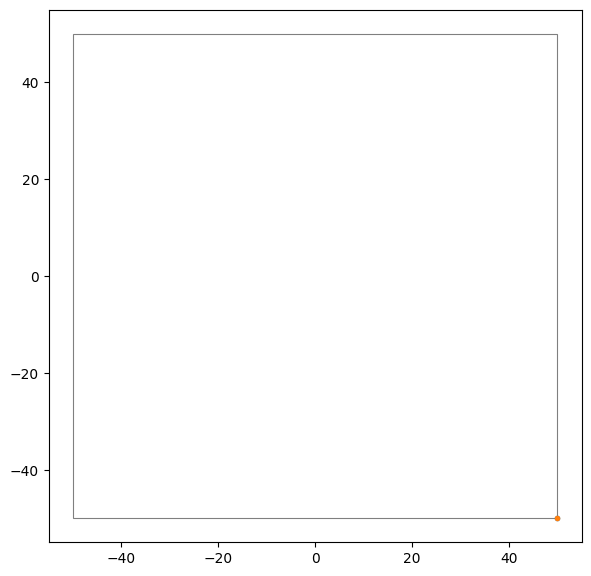

0:Box(-100,-100,100,100),4
├─ 1:Box(0.0,0.0,100,100),1
├─ 2:Box(-100,0.0,0.0,100),1
├─ 3:Box(-100,-100,0.0,0.0),1
└─ 4:Box(0.0,-100,100,0.0),1

0  -> (10, 0.0, -40.0)
1  -> (1, 100, 100)
2  -> (2, -100, 100)
3  -> (3, -100, -100)
4  -> (4, 100, -100)


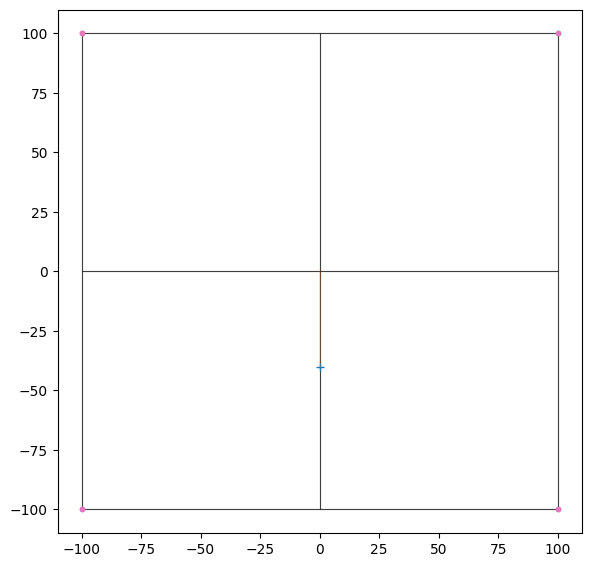

0:Box(-50,-50,50,50),20
├─ 1:Box(0.0,0.0,50,50),6
│  ├─ 2:Box(25.0,25.0,50,50),2
│  │  ├─ 3:Box(37.5,37.5,50,50),0
│  │  ├─ 4:Box(25.0,37.5,37.5,50),1
│  │  ├─ 5:Box(25.0,25.0,37.5,37.5),0
│  │  └─ 6:Box(37.5,25.0,50,37.5),1
│  ├─ 7:Box(0.0,25.0,25.0,50),2
│  │  ├─ 8:Box(12.5,37.5,25.0,50),1
│  │  ├─ 9:Box(0.0,37.5,12.5,50),1
│  │  ├─ 10:Box(0.0,25.0,12.5,37.5),0
│  │  └─ 11:Box(12.5,25.0,25.0,37.5),0
│  ├─ 12:Box(0.0,0.0,25.0,25.0),0
│  └─ 13:Box(25.0,0.0,50,25.0),2
│     ├─ 14:Box(37.5,12.5,50,25.0),1
│     ├─ 15:Box(25.0,12.5,37.5,25.0),0
│     ├─ 16:Box(25.0,0.0,37.5,12.5),0
│     └─ 17:Box(37.5,0.0,50,12.5),1
├─ 18:Box(-50,0.0,0.0,50),5
│  ├─ 19:Box(-25.0,25.0,0.0,50),1
│  ├─ 20:Box(-50,25.0,-25.0,50),2
│  │  ├─ 21:Box(-37.5,37.5,-25.0,50),1
│  │  ├─ 22:Box(-50,37.5,-37.5,50),0
│  │  ├─ 23:Box(-50,25.0,-37.5,37.5),0
│  │  └─ 24:Box(-37.5,25.0,-25.0,37.5),1
│  ├─ 25:Box(-50,0.0,-25.0,25.0),2
│  │  ├─ 26:Box(-37.5,12.5,-25.0,25.0),0
│  │  ├─ 27:Box(-50,12.5,-37.5,25.0),1
│  │  ├─ 28

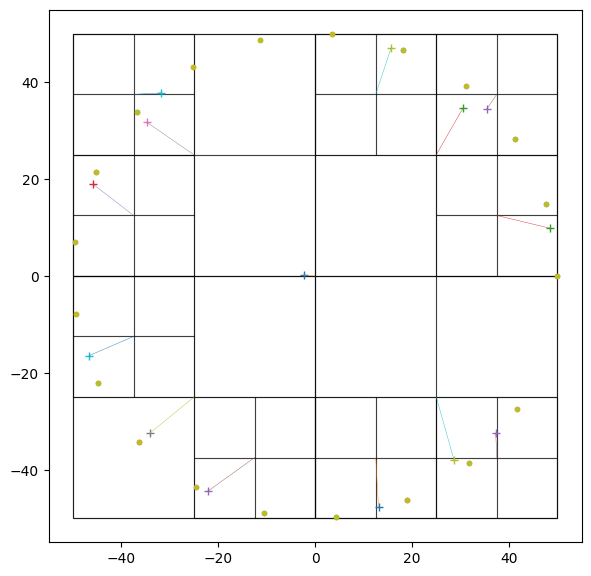

0:Box(-50,-50,50,50),13
├─ 1:Box(0.0,0.0,50,50),0
├─ 2:Box(-50,0.0,0.0,50),0
├─ 3:Box(-50,-50,0.0,0.0),5
│  ├─ 4:Box(-25.0,-25.0,0.0,0.0),0
│  ├─ 5:Box(-50,-25.0,-25.0,0.0),2
│  │  ├─ 6:Box(-37.5,-12.5,-25.0,0.0),0
│  │  ├─ 7:Box(-50,-12.5,-37.5,0.0),1
│  │  ├─ 8:Box(-50,-25.0,-37.5,-12.5),1
│  │  └─ 9:Box(-37.5,-25.0,-25.0,-12.5),0
│  ├─ 10:Box(-50,-50,-25.0,-25.0),1
│  └─ 11:Box(-25.0,-50,0.0,-25.0),2
│     ├─ 12:Box(-12.5,-37.5,0.0,-25.0),0
│     ├─ 13:Box(-25.0,-37.5,-12.5,-25.0),0
│     ├─ 14:Box(-25.0,-50,-12.5,-37.5),1
│     └─ 15:Box(-12.5,-50,0.0,-37.5),1
└─ 16:Box(0.0,-50,50,0.0),4
   ├─ 17:Box(25.0,-25.0,50,0.0),0
   ├─ 18:Box(0.0,-25.0,25.0,0.0),0
   ├─ 19:Box(0.0,-50,25.0,-25.0),2
   │  ├─ 20:Box(12.5,-37.5,25.0,-25.0),0
   │  ├─ 21:Box(0.0,-37.5,12.5,-25.0),0
   │  ├─ 22:Box(0.0,-50,12.5,-37.5),1
   │  └─ 23:Box(12.5,-50,25.0,-37.5),1
   └─ 24:Box(25.0,-50,50,-25.0),2
      ├─ 25:Box(37.5,-37.5,50,-25.0),1
      ├─ 26:Box(25.0,-37.5,37.5,-25.0),0
      ├─ 27:Box(25.0,-50,

AttributeError: 'NoneType' object has no attribute 'x'

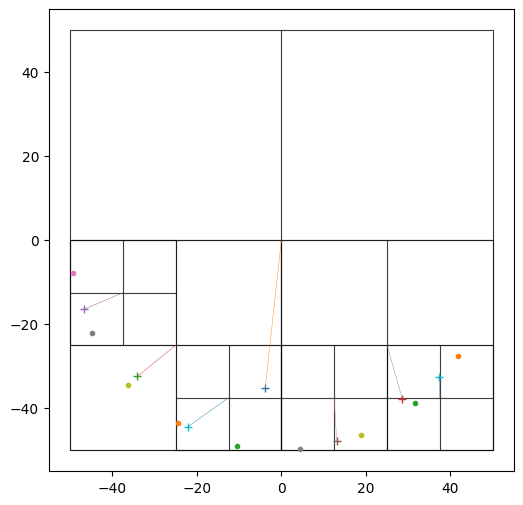

In [21]:
####################################################################
# Some testing code
# DO NOT INCLUDE TESTING CODE IN YOUR SUBMISSION
####################################################################

# First, some cool simulations!

# Include this line for rendering animation in Jupyter notebook 
# Note: need to install jupyter-widgets-jupyterlab-manager
# %matplotlib ipympl
# Otherwise, save as .py and run in terminal / IDE to see animations

# a sun and a planet
P=[Body(1,0,0,0,0),Body(3.0e-6,0,1,4.44,4.44)]
sim = Simulation(P)
sim.show(-4,-4,4,4)

# 3 suns and a planet
sA = Body(10,-10,0,3.14,-5.44)
sB = Body(10,0,0,3.24,5.44)
sC = Body(10,-5,8.660,-6.28,0)
p  = Body(3.0e-6,-10,6,-3,-15)

Bodies=[sA,sB,sC,p]
sim = Simulation(Bodies)
sim.show(-30,-30,30,30) 

# 81 stationary bodies on a grid
P = [None]*81
for y in range(9):
    for x in range(9):
        P[9*y+x] = Body(1,2*x,2*y)

sim = Simulation(P, total_time=1)
sim.show(0,0,20,20)

# 42 moving bodies starting on a circle
P = [None]*42
for i in range(len(P)):
    x  = 50.0 * math.cos(i * 0.3)
    y  = 50.0 * math.sin(i * 0.3)
    vx = 50.0 * math.cos(i * 0.7)
    vy = 50.0 * math.sin(i * 0.7)
    m  = 1.0 + (i % 5)            # masses: 1..5
    P[i] = Body(m, x, y, vx, vy)

sim = Simulation(P)
sim.show(-750,-750,750,750)

# 84 moving bodies starting on two circles
P = [None]*84
for i in range(len(P)//2):
    x  = 50.0 * math.cos(i * 0.3)
    y  = 50.0 * math.sin(i * 0.3)
    vx = 50.0 * math.cos(i * 0.7)
    vy = 50.0 * math.sin(i * 0.7)
    m  = 1.0 + (i % 5)            # masses: 1..5
    P[2*i] = Body(m, x, y, 2*vx, 2*vy)
    P[2*i+1] = Body(m, 2*x, 2*y, vx, vy)

sim = Simulation(P)
sim.show(-750,-750,750,750)


# Question 1

# Tests for Simulation.closestDistance

P = [None]*81
for y in range(9):
    for x in range(9):
        P[9*y+x] = Body(1,2*x,2*y)

sim = Simulation(P)
print(sim.closestDistance())

sim = Simulation(P, total_time=0.5, dt=0.0001)
print(sim.closestDistance())

# Tests for Body.threeBodyProblem

sA = Body(10,-10,0,3.14,-5.44,)
sB = Body(10,0,0,3.24,5.44)
sC = Body(10,-5,8.660,-6.28,0)
p  = Body(3.0e-6,-10,6,-3,-15)
    
Bodies=[sA,sB,sC,p]
print(p.threeBodyProblem(sA,sB,sC,50,50,50))
print(p.threeBodyProblem(sA,sB,sC,45,45,45))


# Question 2
    
# Test 1: 4 equal-mass Bodies on the edges of a square
P = [None]*4
P[0] = Body(1,50,50)
P[1] = Body(1,-50,50)
P[2] = Body(1,-50,-50)
P[3] = Body(1,50,-50)
    
g = Gadget(Box.getBox(P))
for p in P: g.add(p)
print(g)
g.plot()

# Now remove P[0]
g.remove(P[0])
print(g) 
g.plot()

# Now remove all but the last body
g.remove(P[1]); g.remove(P[2])
print(g) 
g.plot()

# Test 2: 4 unequal-mass Bodies on the edges of a square
P = [None]*4
P[0] = Body(1,100,100,0,0)
P[1] = Body(2,-100,100,0,0)
P[2] = Body(3,-100,-100,0,0)
P[3] = Body(4,100,-100,0,0)
    
g = Gadget(Box.getBox(P))
for p in P: g.add(p)
print(g)
g.plot()

# Test 3: 20 Bodies spread on a circle
P = [None]*20
for i in range(20):
    x  = 50.0 * math.cos(i * 0.3)
    y  = 50.0 * math.sin(i * 0.3)
    vx =  5.0 * math.cos(i * 0.7)
    vy =  5.0 * math.sin(i * 0.7)
    m  = 1.0 + (i % 5)            # masses: 1..5
    P[i] = Body(m, x, y, vx, vy)

g = Gadget(Box(-50,-50,50,50))
for p in P: g.add(p)
print(g); g.plot()

for i in range(10): g.remove(P[i])
print(g); g.plot()


# Question 3

def testOnThreeCircles(n):
    P = [None]*3*n
    for i in range(n):
        x  = 50.0 * math.cos(i * 0.3)
        y  = 50.0 * math.sin(i * 0.3)
        vx = 50.0 * math.cos(i * 0.7)
        vy = 50.0 * math.sin(i * 0.7)
        m  = 1.0 + (i % 5)            # masses: 1..5
        P[3*i] = Body(m, x, y, 3*vx, 3*vy)
        P[3*i+1] = Body(m, 2*x, 2*y, 2*vx, 2*vy)
        P[3*i+2] = Body(m, 3*x, 3*y, vx, vy)
    sim = FastSimulation(P, total_time=0.01)
    new_ps = [None]*len(P)
    sim.run(test=new_ps)
    print(f"Experiment with n={n}, new_ps entries:")
    for ps in new_ps: print(len(ps),ps)

testOnThreeCircles(1)
testOnThreeCircles(3)

In [16]:
# Question 1

# Tests for Simulation.closestDistance

P = [None]*81
for y in range(9):
    for x in range(9):
        P[9*y+x] = Body(1,2*x,2*y)

sim = Simulation(P)
print(sim.closestDistance())

sim = Simulation(P, total_time=0.5, dt=0.0001)
print(sim.closestDistance())

# Tests for Body.threeBodyProblem

sA = Body(10,-10,0,3.14,-5.44,)
sB = Body(10,0,0,3.24,5.44)
sC = Body(10,-5,8.660,-6.28,0)
p  = Body(3.0e-6,-10,6,-3,-15)
    
Bodies=[sA,sB,sC,p]
print(p.threeBodyProblem(sA,sB,sC,50,50,50))
print(p.threeBodyProblem(sA,sB,sC,45,45,45))



None
None
0.42
0.0


0:Box(0,0,16,16),81
├─ 1:Box(8.0,8.0,16,16),25
│  ├─ 2:Box(12.0,12.0,16,16),9
│  │  ├─ 3:Box(14.0,14.0,16,16),4
│  │  │  ├─ 4:Box(15.0,15.0,16,16),1
│  │  │  ├─ 5:Box(14.0,15.0,15.0,16),1
│  │  │  ├─ 6:Box(14.0,14.0,15.0,15.0),1
│  │  │  └─ 7:Box(15.0,14.0,16,15.0),1
│  │  ├─ 8:Box(12.0,14.0,14.0,16),2
│  │  │  ├─ 9:Box(13.0,15.0,14.0,16),0
│  │  │  ├─ 10:Box(12.0,15.0,13.0,16),1
│  │  │  ├─ 11:Box(12.0,14.0,13.0,15.0),1
│  │  │  └─ 12:Box(13.0,14.0,14.0,15.0),0
│  │  ├─ 13:Box(12.0,12.0,14.0,14.0),2
│  │  │  ├─ 14:Box(13.0,13.0,14.0,14.0),0
│  │  │  ├─ 15:Box(12.0,13.0,13.0,14.0),0
│  │  │  ├─ 16:Box(12.0,12.0,13.0,13.0),1
│  │  │  └─ 17:Box(13.0,12.0,14.0,13.0),1
│  │  └─ 18:Box(14.0,12.0,16,14.0),1
│  ├─ 19:Box(8.0,12.0,12.0,16),6
│  │  ├─ 20:Box(10.0,14.0,12.0,16),2
│  │  │  ├─ 21:Box(11.0,15.0,12.0,16),0
│  │  │  ├─ 22:Box(10.0,15.0,11.0,16),1
│  │  │  ├─ 23:Box(10.0,14.0,11.0,15.0),1
│  │  │  └─ 24:Box(11.0,14.0,12.0,15.0),0
│  │  ├─ 25:Box(8.0,14.0,10.0,16),2
│  │  │  ├─ 26:Box(

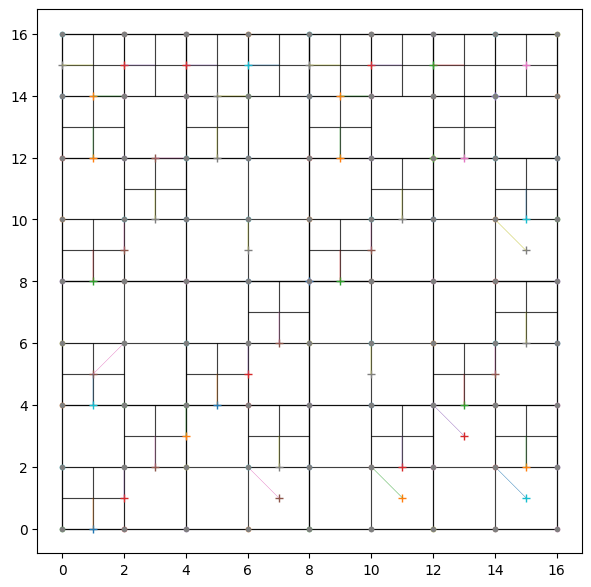

0:Box(0,0,16,16),80
├─ 1:Box(8.0,8.0,16,16),25
│  ├─ 2:Box(12.0,12.0,16,16),9
│  │  ├─ 3:Box(14.0,14.0,16,16),4
│  │  │  ├─ 4:Box(15.0,15.0,16,16),1
│  │  │  ├─ 5:Box(14.0,15.0,15.0,16),1
│  │  │  ├─ 6:Box(14.0,14.0,15.0,15.0),1
│  │  │  └─ 7:Box(15.0,14.0,16,15.0),1
│  │  ├─ 8:Box(12.0,14.0,14.0,16),2
│  │  │  ├─ 9:Box(13.0,15.0,14.0,16),0
│  │  │  ├─ 10:Box(12.0,15.0,13.0,16),1
│  │  │  ├─ 11:Box(12.0,14.0,13.0,15.0),1
│  │  │  └─ 12:Box(13.0,14.0,14.0,15.0),0
│  │  ├─ 13:Box(12.0,12.0,14.0,14.0),2
│  │  │  ├─ 14:Box(13.0,13.0,14.0,14.0),0
│  │  │  ├─ 15:Box(12.0,13.0,13.0,14.0),0
│  │  │  ├─ 16:Box(12.0,12.0,13.0,13.0),1
│  │  │  └─ 17:Box(13.0,12.0,14.0,13.0),1
│  │  └─ 18:Box(14.0,12.0,16,14.0),1
│  ├─ 19:Box(8.0,12.0,12.0,16),6
│  │  ├─ 20:Box(10.0,14.0,12.0,16),2
│  │  │  ├─ 21:Box(11.0,15.0,12.0,16),0
│  │  │  ├─ 22:Box(10.0,15.0,11.0,16),1
│  │  │  ├─ 23:Box(10.0,14.0,11.0,15.0),1
│  │  │  └─ 24:Box(11.0,14.0,12.0,15.0),0
│  │  ├─ 25:Box(8.0,14.0,10.0,16),2
│  │  │  ├─ 26:Box(

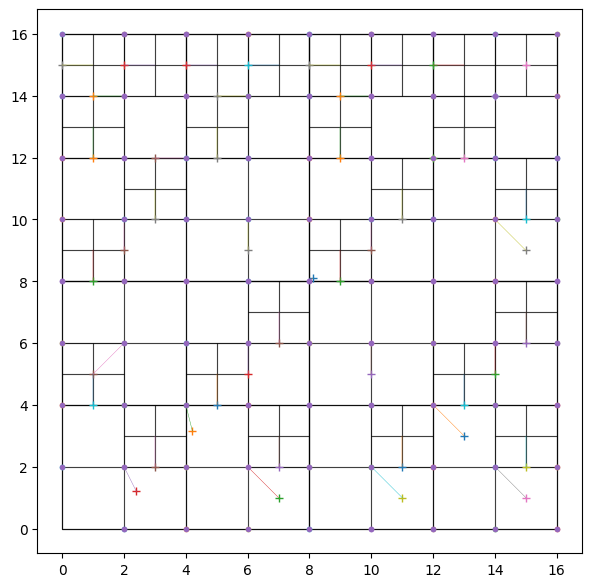

0:Box(0,0,16,16),78
├─ 1:Box(8.0,8.0,16,16),25
│  ├─ 2:Box(12.0,12.0,16,16),9
│  │  ├─ 3:Box(14.0,14.0,16,16),4
│  │  │  ├─ 4:Box(15.0,15.0,16,16),1
│  │  │  ├─ 5:Box(14.0,15.0,15.0,16),1
│  │  │  ├─ 6:Box(14.0,14.0,15.0,15.0),1
│  │  │  └─ 7:Box(15.0,14.0,16,15.0),1
│  │  ├─ 8:Box(12.0,14.0,14.0,16),2
│  │  │  ├─ 9:Box(13.0,15.0,14.0,16),0
│  │  │  ├─ 10:Box(12.0,15.0,13.0,16),1
│  │  │  ├─ 11:Box(12.0,14.0,13.0,15.0),1
│  │  │  └─ 12:Box(13.0,14.0,14.0,15.0),0
│  │  ├─ 13:Box(12.0,12.0,14.0,14.0),2
│  │  │  ├─ 14:Box(13.0,13.0,14.0,14.0),0
│  │  │  ├─ 15:Box(12.0,13.0,13.0,14.0),0
│  │  │  ├─ 16:Box(12.0,12.0,13.0,13.0),1
│  │  │  └─ 17:Box(13.0,12.0,14.0,13.0),1
│  │  └─ 18:Box(14.0,12.0,16,14.0),1
│  ├─ 19:Box(8.0,12.0,12.0,16),6
│  │  ├─ 20:Box(10.0,14.0,12.0,16),2
│  │  │  ├─ 21:Box(11.0,15.0,12.0,16),0
│  │  │  ├─ 22:Box(10.0,15.0,11.0,16),1
│  │  │  ├─ 23:Box(10.0,14.0,11.0,15.0),1
│  │  │  └─ 24:Box(11.0,14.0,12.0,15.0),0
│  │  ├─ 25:Box(8.0,14.0,10.0,16),2
│  │  │  ├─ 26:Box(

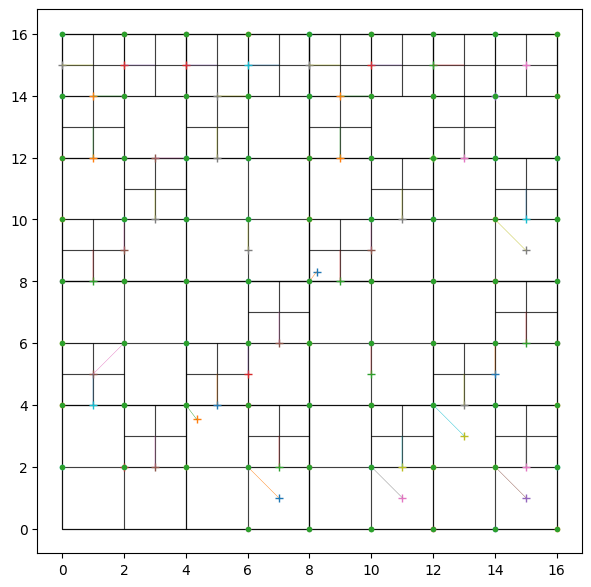

0:Box(-100,-100,100,100),4
├─ 1:Box(0.0,0.0,100,100),1
├─ 2:Box(-100,0.0,0.0,100),1
├─ 3:Box(-100,-100,0.0,0.0),1
└─ 4:Box(0.0,-100,100,0.0),1

0  -> (10, 0.0, -40.0)
1  -> (1, 100, 100)
2  -> (2, -100, 100)
3  -> (3, -100, -100)
4  -> (4, 100, -100)


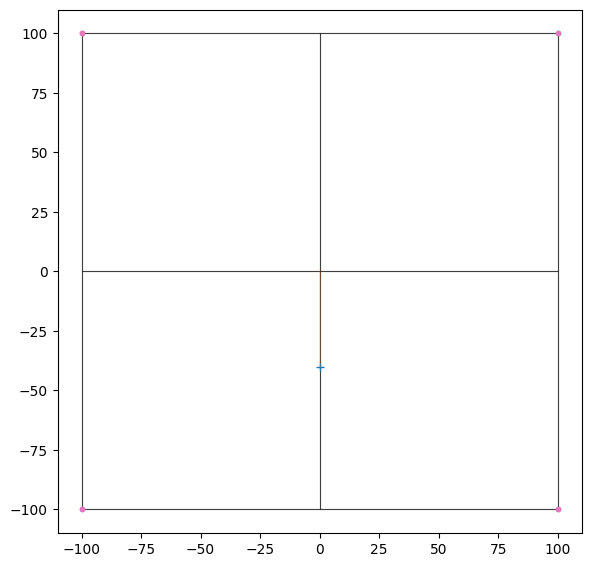

In [17]:
g = Gadget(Box.getBox(P))
for p in P: g.add(p)
print(g)
g.plot()

# Now remove P[0]
g.remove(P[0])
print(g) 
g.plot()

# Now remove all but the last body
g.remove(P[1]); g.remove(P[2])
print(g) 
g.plot()

# Test 2: 4 unequal-mass Bodies on the edges of a square
P = [None]*4
P[0] = Body(1,100,100,0,0)
P[1] = Body(2,-100,100,0,0)
P[2] = Body(3,-100,-100,0,0)
P[3] = Body(4,100,-100,0,0)
    
g = Gadget(Box.getBox(P))
for p in P: g.add(p)
print(g)
g.plot()



In [20]:
# Question 3

def testOnThreeCircles(n):
    P = [None]*3*n
    for i in range(n):
        x  = 50.0 * math.cos(i * 0.3)
        y  = 50.0 * math.sin(i * 0.3)
        vx = 50.0 * math.cos(i * 0.7)
        vy = 50.0 * math.sin(i * 0.7)
        m  = 1.0 + (i % 5)            # masses: 1..5
        P[3*i] = Body(m, x, y, 3*vx, 3*vy)
        P[3*i+1] = Body(m, 2*x, 2*y, 2*vx, 2*vy)
        P[3*i+2] = Body(m, 3*x, 3*y, vx, vy)
    sim = FastSimulation(P, total_time=0.01)
    new_ps = [None]*len(P)
    sim.run(test=new_ps)
    print(f"Experiment with n={n}, new_ps entries:")
    for ps in new_ps: print(len(ps),ps)

testOnThreeCircles(1)
testOnThreeCircles(3)

Experiment with n=1, new_ps entries:
2 [Body(1.0,50.0,0.0,150.0,0.0), Body(2.0,125.0,0.0,0,0)]
3 [Body(1.0,50.0,0.0,150.0,0.0), Body(1.0,100.0,0.0,100.0,0.0), Body(1.0,150.0,0.0,50.0,0.0)]
3 [Body(1.0,50.0,0.0,150.0,0.0), Body(1.0,100.0,0.0,100.0,0.0), Body(1.0,150.0,0.0,50.0,0.0)]
Experiment with n=3, new_ps entries:
8 [Body(1.0,150.0,0.0,50.0,0.0), Body(1.0,100.0,0.0,100.0,0.0), Body(1.0,50.0,0.0,150.0,0.0), Body(2.0,47.7668244562803,14.776010333066978,114.72632809267327,96.63265308565366), Body(3.0,41.26678074548391,28.23212366975177,25.49507143503616,147.81745949826905), Body(2.0,95.5336489125606,29.552020666133956,76.48421872844885,64.4217687237691), Body(3.0,82.53356149096783,56.46424733950354,16.996714290024105,98.54497299884602), Body(5.0,131.6003946894074,68.54903500523355,0,0)]
8 [Body(1.0,150.0,0.0,50.0,0.0), Body(1.0,100.0,0.0,100.0,0.0), Body(3.0,48.51121630418686,9.850673555377986,0,0), Body(3.0,41.26678074548391,28.23212366975177,25.49507143503616,147.81745949826905), Bo